# Interpolation Testing

This notebook tests interpolation of pollutant concentrations using nearby sensor data collected through [OpenAQ](https://openaq.org/).

In [3]:
# Adding project root to the path in order to enable imports from sibling directories
import os
import sys

sys.path.append(os.path.abspath('..'))

In [40]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from analysis.idw_interpolation import PredictPollutant

In [27]:
# Load in one month of data for testing
df = pd.read_csv('../raw_data/maryland_data_2020_01.csv')

# Filter data for PM2.5 on January 1st, 2020 at 08:00 UTC
pollutant = 'pm25'
year = 2020
month = 1
day = 1
hour = 8

filtered_df = df[
    (df['parameter'] == pollutant) &
    (df['year'] == year) &
    (df['month'] == month) &
    (df['day'] == day) &
    (df['hour'] == hour)
]

In [ ]:
# Perform predictions for all of the rows in the filtered DataFrame
true_vals = []
predicted_vals = []

for idx, row in filtered_df.iterrows():
    # Retrieve the latitude, longitude, and PM2.5 concentration of the random row
    lat = row['latitude']
    lon = row['longitude']
    true_val = row['value']
    coords = (lat, lon)

    # Create a temporary DataFrame without the current row
    df_temp = filtered_df.drop(index=idx)

    # Use inverse distance weighting interpolation to find the predicted concentration
    try:
        prediction = PredictPollutant(df_temp, coords, n_sensors=4,
                                      pollutant='pm25', year=2020, month=1, day=1, hour=8)
        true_vals.append(true_val)
        predicted_vals.append(prediction)
    except Exception as e:
        print(f'Skipping index {idx} due to error: {e}')

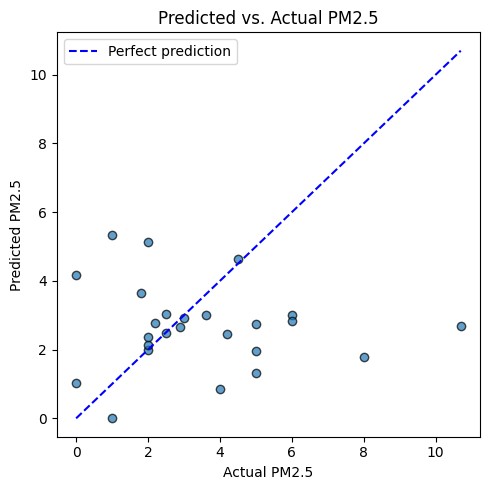

Mean Absolute Error (MAE): 2.10
Root Mean Squared Error (RMSE): 2.93
R² Score: -0.47


In [42]:
# Create a visualization of the true vs. predicted values
plt.figure(figsize=(5, 5))
plt.scatter(true_vals, predicted_vals, alpha=0.7, edgecolors='k')
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'b--', label='Perfect prediction')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Predicted vs. Actual PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

# Compute metrics
mae = mean_absolute_error(true_vals, predicted_vals)
rmse = np.sqrt(mean_squared_error(true_vals, predicted_vals))
r2 = r2_score(true_vals, predicted_vals)

# Print results
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R² Score: {r2:.2f}')